In [31]:
import numpy as np
import pandas as pd
import os
import time
import schedule
import joblib
import datetime 
import multiprocessing as mp
from get_strategy_meta import get_all_strategy_meta
from query_api import get_path_dict, gen_connection, load_item_by_key, query_mysql
from get_signal_mongo import write_signal_mongo, get_signal_mongo
from get_signal_mysql import write_signal, get_signal
from mongo_functions import get_portfolio_db

from mongo_datetime import dtnow, dt, get_collection

In [32]:
from bson.codec_options import CodecOptions
import pytz


# Check Log

In [82]:
db_name = "MLLog"
coll_name = "log"
db = get_portfolio_db(db_name)
coll = get_collection(db, coll_name)
# r = coll.find({"code":"W006", "key":"s_AUDUSD"})
# r = coll.find({"code": "X004", "key": "s_TLT"})
cond = {"idd.code": "Z001", "idd.key":"b_XAGUSD"}
# cond = {}
r = coll.find(cond)
df = pd.DataFrame([j for j in r])
# df.sort_values("time")
df.tail(150)

,Date,_id,idd,message,other
174803,2019-07-14 21:47:40.568000-04:00,5d2bdb3ccfc7598261c310c3,"{'code': 'Z001', 'key': 'b_XAGUSD'}",Using Mongo: 2019-07-10 21:45:00-04:00 - 2019-...,
174804,2019-07-14 21:47:51.033000-04:00,5d2bdb47cfc7598261c310c5,"{'code': 'Z001', 'key': 'b_XAGUSD'}",Scaling: Done!,
174805,2019-07-14 21:47:51.035000-04:00,5d2bdb47cfc7598261c310c6,"{'code': 'Z001', 'key': 'b_XAGUSD'}",TimeseriesGenerator: Done!,
174806,2019-07-14 21:47:54.861000-04:00,5d2bdb4acfc7598261c310c7,"{'code': 'Z001', 'key': 'b_XAGUSD'}",Model Loaded!,
174807,2019-07-14 21:47:55.769000-04:00,5d2bdb4bcfc7598261c310c8,"{'code': 'Z001', 'key': 'b_XAGUSD'}",Predict: Done!,
174808,2019-07-14 21:47:55.770000-04:00,5d2bdb4bcfc7598261c310c9,"{'code': 'Z001', 'key': 'b_XAGUSD'}",b_XAGUSD,"{'last_date': 2019-07-14 21:45:00-04:00, 'quer..."
174809,2019-07-14 17:50:31.497000-04:00,5d2bdbe776b63312c280bbe9,"{'code': 'Z001', 'key': 'b_XAGUSD'}","Loaded: scaler, DATA_PARAMS, MODEL_PARAMS, model.",
174810,2019-07-14 17:50:31.519000-04:00,5d2bdbe776b63312c280bbea,"{'code': 'Z001', 'key': 'b_XAGUSD'}",Loaded: MINUTE_INDEX for XAGUSD,
174811,2019-07-14 17:50:31.520000-04:00,5d2bdbe776b63312c280bbeb,"{'code': 'Z001', 'key': 'b_XAGUSD'}",Using Mongo: 2019-07-10 21:50:00 - 2019-07-14 ...,
174812,2019-07-14 17:50:37.894000-04:00,5d2bdbed76b63312c280bbed,"{'code': 'Z001', 'key': 'b_XAGUSD'}",Scaling: Done!,


# Check Signal

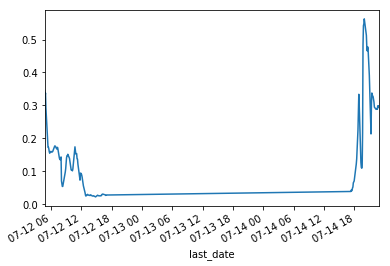

In [139]:
from bson.objectid import ObjectId 

db_name = "MLProduction"
coll_name = "SignalOneLiveU3"
db = get_portfolio_db(db_name)
coll = get_collection(db, coll_name)

dd = dt(2019,7,12,0,0,0)
cond = {"code": "Z007", "key": "b_EURJPY", "last_date": {"$gte":dd}}
# cond = {"code": "Z001", "key": "b_XAGUSD", "last_date": {"$gte":dd}}
# cond = {"code": "W008", "key": "b_XLY", "last_date": {"$gte":dd}}
# cond = {"_id": ObjectId("5d26ad725fad509917f167e9")}
r = coll.find(cond)
df = pd.DataFrame([j for j in r])
df = df.set_index("last_date")
df.y.plot()



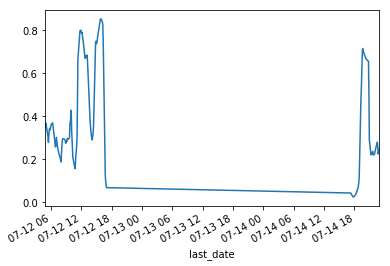

In [140]:
from bson.objectid import ObjectId 

db_name = "MLProduction"
coll_name = "SignalOneLiveU3"
db = get_portfolio_db(db_name)
coll = get_collection(db, coll_name)

dd = dt(2019,7,12,0,0,0)
cond = {"code": "Z007", "key": "s_EURJPY", "last_date": {"$gte":dd}}
# cond = {"code": "Z001", "key": "s_XAGUSD", "last_date": {"$gte":dd}}
# cond = {"code": "W008", "key": "b_XLY", "last_date": {"$gte":dd}}
# cond = {"_id": ObjectId("5d26ad725fad509917f167e9")}
r = coll.find(cond)
df2 = pd.DataFrame([j for j in r])
df2 = df2.set_index("last_date")
df2.y.plot()



In [141]:
df2["yshort"] = (df2["y"] >= 0.5) & (df["y"] < 0.5)
df2["ylong"] = (df2["y"] < 0.5) & (df["y"] >= 0.5)

In [143]:
df2[df2["yshort"] > 0]

,_id,code,key,query_date,status,status_code,timeframe,write_time,y,yshort,ylong
last_date,,,,,,,,,,,
2019-07-12 11:20:00-04:00,5d28a6637a1e1580dfc310ca,Z007,s_EURJPY,2019-07-12 11:20:00-04:00,Successful.,1,5,2019-07-12 11:25:23.897000-04:00,0.667468,True,False
2019-07-12 11:45:00-04:00,5d28ac052cd9603055c310ca,Z007,s_EURJPY,2019-07-12 11:45:00-04:00,Successful.,1,5,2019-07-12 11:49:25.690000-04:00,0.799426,True,False
2019-07-12 11:50:00-04:00,5d28ad37f8ad19c33dc310ca,Z007,s_EURJPY,2019-07-12 11:50:00-04:00,Successful.,1,5,2019-07-12 11:54:31.326000-04:00,0.799869,True,False
2019-07-12 11:55:00-04:00,5d28ae6ab2421cda7cc310ca,Z007,s_EURJPY,2019-07-12 11:55:00-04:00,Successful.,1,5,2019-07-12 11:59:38.279000-04:00,0.801583,True,False
2019-07-12 12:00:00-04:00,5d28b022bb2a96f149c310ca,Z007,s_EURJPY,2019-07-12 12:00:00-04:00,Successful.,1,5,2019-07-12 12:06:58.709000-04:00,0.792309,True,False
2019-07-12 12:05:00-04:00,5d28b154427e15a1a4c310ca,Z007,s_EURJPY,2019-07-12 12:05:00-04:00,Successful.,1,5,2019-07-12 12:12:04.075000-04:00,0.788249,True,False
2019-07-12 12:10:00-04:00,5d28b2842d59062c8fc310ca,Z007,s_EURJPY,2019-07-12 12:10:00-04:00,Successful.,1,5,2019-07-12 12:17:08.993000-04:00,0.790449,True,False
2019-07-12 12:20:00-04:00,5d28b43ca32eab7fafc310ca,Z007,s_EURJPY,2019-07-12 12:20:00-04:00,Successful.,1,5,2019-07-12 12:24:28.320000-04:00,0.756211,True,False
2019-07-12 12:25:00-04:00,5d28b56ee4e807cebac310ca,Z007,s_EURJPY,2019-07-12 12:25:00-04:00,Successful.,1,5,2019-07-12 12:29:34.221000-04:00,0.743807,True,False


In [92]:
from bson.objectid import ObjectId 

db_name = "MLProduction"
coll_name = "SignalOneLiveU3"
db = get_portfolio_db(db_name)
coll = get_collection(db, coll_name)

dd = dt(2019,7,12,0,0,0)
cond = {"code": "Z007", "key": "s_XAGUSD", "last_date": {"$gte":dd}}
# cond = {"code": "W008", "key": "b_XLY", "last_date": {"$gte":dd}}
# cond = {"_id": ObjectId("5d2be4677a69f497efc310ca")}
r = coll.find(cond)
df = pd.DataFrame([j for j in r])
# df = df.set_index("last_date")
# df.y.plot()
df.tail()


,_id,code,key,last_date,query_date,status,status_code,timeframe,write_time,y
588,5d2be4d62d0caae351c310ca,Z007,s_XAGUSD,2019-07-14 22:25:00-04:00,2019-07-14 22:25:00-04:00,Successful.,1,5,2019-07-14 22:28:38.844000-04:00,0.899127
589,5d2be589adc8c1682dc310ca,Z007,s_XAGUSD,2019-07-14 22:25:00-04:00,2019-07-14 22:25:00-04:00,Successful.,1,5,2019-07-14 22:31:37.844000-04:00,0.899127
590,5d2be6b9a55ca50040c310ca,Z007,s_XAGUSD,2019-07-14 22:30:00-04:00,2019-07-14 22:30:00-04:00,Successful.,1,5,2019-07-14 22:36:41.382000-04:00,0.906522
591,5d2be76d9d1994b5cac310ca,Z007,s_XAGUSD,2019-07-14 22:35:00-04:00,2019-07-14 22:35:00-04:00,Successful.,1,5,2019-07-14 22:39:41.644000-04:00,0.898047
592,5d2be820466325e52bc310ca,Z007,s_XAGUSD,2019-07-14 22:35:00-04:00,2019-07-14 22:35:00-04:00,Successful.,1,5,2019-07-14 22:42:40.384000-04:00,0.898047


In [93]:
df.loc[df.y > 0.5]

,_id,code,key,last_date,query_date,status,status_code,timeframe,write_time,y
0,5d2849c04df6cffff7c310ca,Z007,s_XAGUSD,2019-07-12 04:45:00-04:00,2019-07-12 04:45:00-04:00,Successful.,1,5,2019-07-12 04:50:08.154000-04:00,0.869085
1,5d284b728c51bc1833c310ca,Z007,s_XAGUSD,2019-07-12 04:50:00-04:00,2019-07-12 04:50:00-04:00,Successful.,1,5,2019-07-12 04:57:22.791000-04:00,0.873118
2,5d284ca4f82685b73fc310ca,Z007,s_XAGUSD,2019-07-12 04:55:00-04:00,2019-07-12 04:55:00-04:00,Successful.,1,5,2019-07-12 05:02:28.698000-04:00,0.877999
3,5d284dd711a3cc471dc310ca,Z007,s_XAGUSD,2019-07-12 05:00:00-04:00,2019-07-12 05:00:00-04:00,Successful.,1,5,2019-07-12 05:07:35.134000-04:00,0.875829
4,5d285370b10f0c17cec310ca,Z007,s_XAGUSD,2019-07-12 05:25:00-04:00,2019-07-12 05:25:00-04:00,Successful.,1,5,2019-07-12 05:31:28.836000-04:00,0.858784
5,5d2854a2cda4a92959c310ca,Z007,s_XAGUSD,2019-07-12 05:30:00-04:00,2019-07-12 05:30:00-04:00,Successful.,1,5,2019-07-12 05:36:34.459000-04:00,0.760087
6,5d2855e054f90de4d2c310ca,Z007,s_XAGUSD,2019-07-12 05:35:00-04:00,2019-07-12 05:35:00-04:00,Successful.,1,5,2019-07-12 05:41:52.893000-04:00,0.517939
9,5d285a08c89a831f4fc310ca,Z007,s_XAGUSD,2019-07-12 05:50:00-04:00,2019-07-12 05:50:00-04:00,Successful.,1,5,2019-07-12 05:59:36.380000-04:00,0.521299
10,5d285bbfbf815929ecc310ca,Z007,s_XAGUSD,2019-07-12 06:00:00-04:00,2019-07-12 06:00:00-04:00,Successful.,1,5,2019-07-12 06:06:55.080000-04:00,0.806448
11,5d285cf1e72b9af1cbc310ca,Z007,s_XAGUSD,2019-07-12 06:05:00-04:00,2019-07-12 06:05:00-04:00,Successful.,1,5,2019-07-12 06:12:01.887000-04:00,0.833553


In [28]:
cond = {"code": "Z001", "key": "b_XAGUSD",}
r = coll.find(cond)
df = pd.DataFrame([j for j in r])
df.tail(5)

,_id,code,key,last_date,query_date,status,status_code,timeframe,write_time,y
2,5d284be3a5b86a5860c310ca,Z001,b_XAGUSD,2019-07-12 04:55:00-04:00,2019-07-12 04:55:00-04:00,Successful.,1,5,2019-07-12 04:59:15.837000-04:00,0.109733
3,5d284d1699ff420c5ec310ca,Z001,b_XAGUSD,2019-07-12 05:00:00-04:00,2019-07-12 05:00:00-04:00,Successful.,1,5,2019-07-12 05:04:22.048000-04:00,0.111017
4,5d2852af4d0c06bbc4c310ca,Z001,b_XAGUSD,2019-07-12 05:25:00-04:00,2019-07-12 05:25:00-04:00,Successful.,1,5,2019-07-12 05:28:15.974000-04:00,0.314069
5,5d2853e190808c6a53c310ca,Z001,b_XAGUSD,2019-07-12 05:30:00-04:00,2019-07-12 05:30:00-04:00,Successful.,1,5,2019-07-12 05:33:21.129000-04:00,0.388726
6,5d28551762dcc1d0c3c310ca,Z001,b_XAGUSD,2019-07-12 05:35:00-04:00,2019-07-12 05:35:00-04:00,Successful.,1,5,2019-07-12 05:38:31.320000-04:00,0.372132


In [ ]:
datetime.datetime.utcnow()

In [ ]:

db_name = "Production"
coll_name = "prices"
db = get_portfolio_db(db_name)
aware_times = db[coll_name]
result = aware_times.find()
pd.DataFrame([j for j in result]).tail()

In [ ]:
datetime.datetime.now()

In [ ]:
datetime.datetime.utcnow()

In [ ]:
initial_tz='UTC'
converted_tz='US/Eastern'
# df["last_date"] = df["last_date"].dt.tz_localize(initial_tz)
df["last_date"] = df["last_date"].dt.tz_convert(converted_tz)     

In [ ]:
from bson.objectid import ObjectId 

db_name = "MLProduction"
coll_name = "SignalOneLive2"
db = get_portfolio_db(db_name)
coll = db[coll_name]
cond = {"_id": ObjectId("5d27d84706a26bddba27eb7e")}
# cond = {"code": "Z001", "key": "b_XAGUSD"}
r = coll.find(cond)
df = collection_to_df(r, ["last_date","query_date", "write_time"])
df.tail(10)



In [ ]:

df = df.drop(columns = ["_id"], axis = 1)
db_name = "MLProduction"
coll_name = "SignalOneLive2"
db = get_portfolio_db(db_name)
coll = db["testingdate"]
d_nonadj = df.to_dict(orient= "records")


In [ ]:
r = coll.find()
df = collection_to_df(r, ["last_date","query_date", "write_time"])
df.tail(10)

In [ ]:
r = coll.find()
df = pd.DataFrame([j for j in r])
df

In [ ]:

coll.insert_many(d_nonadj)

In [ ]:
db_name = "MLProduction"
coll_name = "SignalOneLive2"
db = get_portfolio_db(db_name)
coll = db[coll_name]
# r = coll.find({"code":"W006", "key":"s_AUDUSD"})
# r = coll.find({"code": "X004", "key": "s_TLT"})
cond = {"code": "Y001"}
cond = {"code": "W006", "key": "b_USDCAD"}
cond = {}
r = coll.find(cond)
df = pd.DataFrame([j for j in r])
# df.tail(10)
df["dd"] = [j.total_seconds()/60 for j in (df["write_time"] - df["query_date"])]
print(df.shape)
df.sort_values(["dd", "timeframe"], ascending = False)
df.sort_values(["code","key"], ascending = True)

In [ ]:
# df.set_index("query_date")["y"].plot()

# Check prices

In [ ]:
# %%time
db_name = "Production"
coll_name = "prices"
db = get_portfolio_db(db_name)
coll = db[coll_name]
name_list = coll.distinct("name")
r = coll.find({"name": "EFA"})
df = pd.DataFrame([j for j in r])
df = df.set_index("time")
df.index.is_monotonic_increasing
df.head()
df.tail()
df["price"].plot()
dp_list = []
for name in name_list:
    r = coll.find({"name": name})
    df = pd.DataFrame([j for j in r])
    df = df.set_index("time")
    print(name, df.index.max()- df.index.min())
    if df.index.duplicated().any():
        dp_list.append(name)
    
print(len(name_list))
",".join(dp_list)

In [ ]:
my_date = datetime.datetime.now(pytz.timezone('US/Eastern'))
# my_date = datetime.datetime.now()
my_date

In [ ]:
my_date = datetime.datetime(2019,7,12,2,30,0, tzinfo = pytz.timezone('US/Eastern'))

In [ ]:
db_name = "Production"
coll_name = "prices"
db = get_portfolio_db(db_name)
coll = db[coll_name]
r = coll.find({"name": "NZDUSD", "time":{"$lte": my_date}})
# r = coll.find({"name": "NZDUSD"})
pdf = pd.DataFrame([j for j in r])
pdf.tail()
# pdf = pdf.set_index("time")
# d = pdf.index[pdf.index.duplicated()]
# pdf.loc[d]



In [ ]:
my_date = datetime.datetime.now(pytz.timezone('US/Pacific'))
my_date

In [ ]:
import pytz
my_date = datetime.datetime.now(pytz.timezone('US/Eastern'))

db_name = "Production"
coll_name = "prices"
db = get_portfolio_db(db_name)
coll = db[coll_name]
my_date = datetime.datetime.now()
my_date = datetime.datetime.now(pytz.timezone('US/Eastern'))
my_date

r = coll.find({"name": "NZDUSD", "time":{"$lte":my_date}})
pdf = pd.DataFrame([j for j in r])
pdf.tail()
# pdf = pdf.set_index("time")
# d = pdf.index[pdf.index.duplicated()]
# pdf.loc[d]



In [ ]:
pdf.index.duplicated()

In [ ]:
df.set_index("query_date")["status_code"].plot()

In [ ]:
timeframe = 5

In [ ]:
price_db ="Production"
price_coll = "prices"
d2 = datetime.datetime.now()
d1 = d2 - datetime.timedelta(1,0,0)
prod_db = get_portfolio_db(price_db)
coll = prod_db[price_coll]
result = coll.find({"time": {"$gte": d1, "$lte": d2}})
price_df = pd.DataFrame([j for j in result])
price_df["name"] = price_df["name"].str.replace('@', '')
price_df = price_df.pivot(index='time', columns='name', values='price')
price_df = price_df.reset_index()
price_df = price_df.rename(columns={"time": "Date"})
price_df = price_df.set_index("Date")

if not price_df.index.is_monotonic_increasing:
    price_df = price_df.sort_index(ascending=True)

price_df = price_df.resample("{}min".format(timeframe), how = "last",label='right', closed = "right")
print(price_df.head(5))
print(price_df.tail(5))

In [ ]:
prod_db = get_portfolio_db(price_db)
coll = prod_db[price_coll]
result = coll.find({"time": {"$gte": d1, "$lte": d2}})
price_df2 = pd.DataFrame([j for j in result])
price_df2.tail()

In [ ]:
d2.day

In [ ]:
corrected_minute = d2.minute - d2.minute % 15
query_date = datetime.datetime(d2.year, d2.month, d2.day, d2.hour, corrected_minute)